In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [14]:
def predict(df_org, asof):
    df = df_org.copy()
    df['number'] = [i for i in range(len(df))]
    df['day_of_year'] = df.index.dayofyear
    df['log_Passengers'] = np.log(df['Passengers'])
    df['trend_log_Passengers'] = df['log_Passengers'].rolling(12, min_periods=12).mean()
    df['season_log_Passengers'] = df['log_Passengers'] - df['trend_log_Passengers']
    df = df[12:]
    
    tr_df = df.loc[df.index <= asof].dropna()
    tr_df_reg = tr_df.iloc[-12:].dropna()
    
    reg = LinearRegression()
    reg.fit(tr_df_reg[['number']], tr_df_reg['trend_log_Passengers'])
    
    model = RandomForestRegressor(n_estimators = 50, random_state = 42)
    model.fit(tr_df[['day_of_year']], tr_df['season_log_Passengers'])
    
    df['pr_trend_log_Passengers'] = reg.predict(df[['number']])
    cnd1 = (df.index <= asof) & (~df['trend_log_Passengers'].isna())
    df.loc[cnd1, 'pr_trend_log_Passengers'] = df.loc[cnd1, 'trend_log_Passengers']
    
    df['pr_season_log_Passengers'] = model.predict(df[['day_of_year']])
    cnd2 = (df.index <= asof) & (~df['season_log_Passengers'].isna())
    df.loc[cnd2, 'pr_season_log_Passengers'] = df.loc[cnd2, 'season_log_Passengers']
    
    df['Prediction'] = np.exp(df['pr_trend_log_Passengers'] + df['pr_season_log_Passengers'])
    
    return df

In [15]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

In [16]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [17]:
start = df.index.max() + pd.offsets.MonthBegin()
end = start + pd.offsets.YearEnd(5)
months = [d - pd.offsets.MonthBegin() for d in pd.date_range(start, end, freq='M')]
add_df = pd.DataFrame().from_dict({'Month': months})
for c in df.columns:
    add_df[c] = np.nan
add_df = add_df.set_index('Month')

In [18]:
new_df = pd.concat([df, add_df])
new_df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


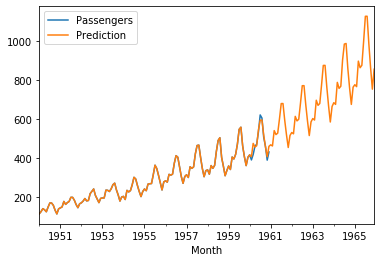

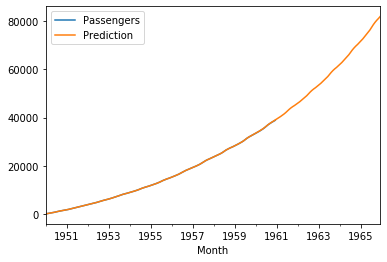

In [19]:
p_df = predict(new_df, pd.Timestamp('1960-01-01'))
p_df[['Passengers', 'Prediction']].plot()
plt.show()
p_df[['Passengers', 'Prediction']].cumsum().plot()
plt.show()

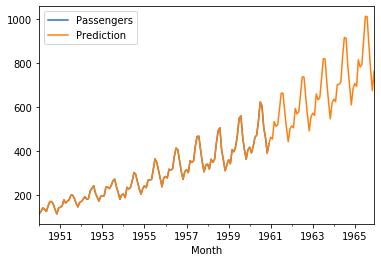

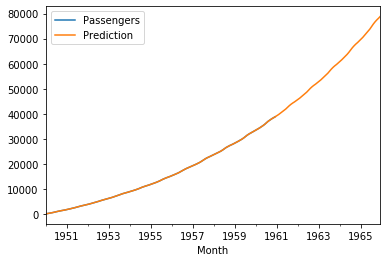

In [24]:
p_df = predict(new_df, pd.Timestamp('1962-01-01'))
p_df[['Passengers', 'Prediction']].plot()
plt.show()
p_df[['Passengers', 'Prediction']].cumsum().plot()
plt.show()